# Extended Hybrid Money Plot

**Goal:** Manuel just wanted a money plot showing how much better RNNIP was doing over the Topo recommendations, just with an overall roc curve for Topo jets, so that's what I'm going to do right here :)

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Step 1: Open the df and keras processed datasets

In [2]:
physicsSample='ttbar'
trainPhysicsSample='hybrid_5TeV'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
df_tag = '2mtest_15trks_sd0_rev'
Ntrain=5e6

In [3]:
# Load in the sample for evaluation
subDir = 'mc16d_PFlow_'+physicsSample
dataDir = '../../data/'+subDir
scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
dataTagTest = "2mtest_15trks_{}_sd0_rev{}".format(vStr, scale_tag)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

_,_,nFeatures = X.shape

# Also open the df so that you'll have access to the jet pt and eta
jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')



### Step 2: Load in the EMTopo recommendation

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


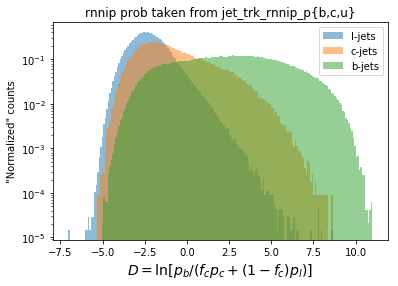

In [8]:
# Save the efficiencies from the previous training in a separate list
leffs, ceffs, beffs, discs = [], [], [], []
fc = 0.07
nBins = 200

# Evaluate Zihao's model
plt.figure()

disc = np.log(jet_df.rnnip_pb / (fc*jet_df.rnnip_pc + (1-fc)*jet_df.rnnip_pu))
#disc[jet_df.ip3d_ntrk == 0] = -8

myRange = (disc.min(),disc.max())

for pdg, flav in zip([0,4,5],['l','c','b']):

    n,_,_ = plt.hist(disc[jet_df.LabDr_HadF == pdg],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5,
                     density=True, log=True) 

    # Calculate the eff
    eff = calculateEff(n)

    if pdg == 0:
        leffs.append(eff)
    elif pdg == 4:
        ceffs.append(eff)
    elif pdg == 5:
        beffs.append(eff)

plt.legend()
plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
plt.ylabel('"Normalized" counts')
plt.title("rnnip prob taken from jet_trk_rnnip_p{b,c,u}")
plt.show()


### Step 3: Load in the keras model and get the discriminant

Initialize method from myModel()
Loading previously trained LSTM
min: -10.11, max: 11.99


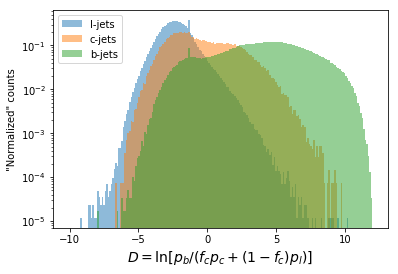

In [9]:
# Load in the model
nHidden = 200
figDir = '../../figures'
modelDir = "../../models/mc16d_PFlow_"+trainPhysicsSample
dataTagTrain = "{}train_15trks_{}_sd0_rev".format(nJetsTag(Ntrain),vStr)
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

# Get the efficiencies
tag = '_eval_{}'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
(leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

discs.append(d)


### Step 4: Make the plot

In [6]:
len(leffs)

2

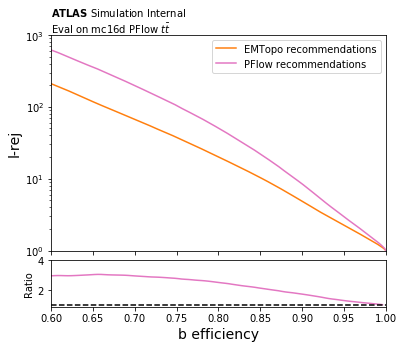

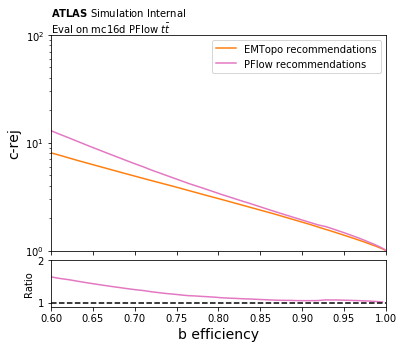

In [15]:
labels = ['EMTopo recommendations','PFlow recommendations']
colors = ['C1','C6']

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d PFlow $t\bar{t}$"

plotTag='-rej_ws_plot'

plotROCRatio(beffs, leffs, labels, 
             rrange=(0.9,4),colors=colors,ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,
             figDir=figDir,subDir=subDir,tag='l'+plotTag)
plotROCRatio(beffs, ceffs, labels, 
             rrange=(0.9,2),colors=colors,ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,
             figDir=figDir,subDir=subDir,tag='c'+plotTag)

The efficiency of my training is a little lower than I remembered... it must be from the new JVT cut.